In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline
import seaborn as sns
import platform
from matplotlib import font_manager , rc

if platform.system() == 'Darwin':
  rc('font' , family = 'AppleGothic')
elif platform.system() == 'Windows':
  path = 'C:/Windows/Fonts/malgun.ttf'
  font_name = font_manager.FontProperties(fname = path).get_name()
  rc('font' , family = font_name)
else:
  print('모름')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
#필요한 모델들
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.linear_model import LinearRegression , Ridge , LogisticRegression
from sklearn.model_selection import GridSearchCV , train_test_split , cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score , classification_report , confusion_matrix , accuracy_score , f1_score , roc_curve, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 문제 정의
 - 수질 지표의 지수에 따라 이 물이 먹어도 되는지 안되는지에 대해 판단하기

## 데이터셋 로딩

In [3]:
data = pd.read_csv('water_potability.csv')

## 데이터 탐색

- pH: 물의 pH 수준.
- Hardness: 물의 경도, 미네랄 함량의 척도
- Solids: 물에 용해된 총 고형물
- Chloramines: 물 속의 클로라민 농도.
- Sulfate: 물 속의 황산염 농도.
- Conductivity: 물의 전기 전도도.
- Organic_carbon: 물 속 유기탄소 함량.
- Trihalomethanes: 물 속의 트리할로메탄 농도.
- Turbidity: 탁도 수준, 물의 투명도를 나타내는 척도.
- Potability: target(0 : 불가 , 1: 가능)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- 결측치가 많음.

- 복사본 생성

In [5]:
data1 = data.dropna(axis = 0)

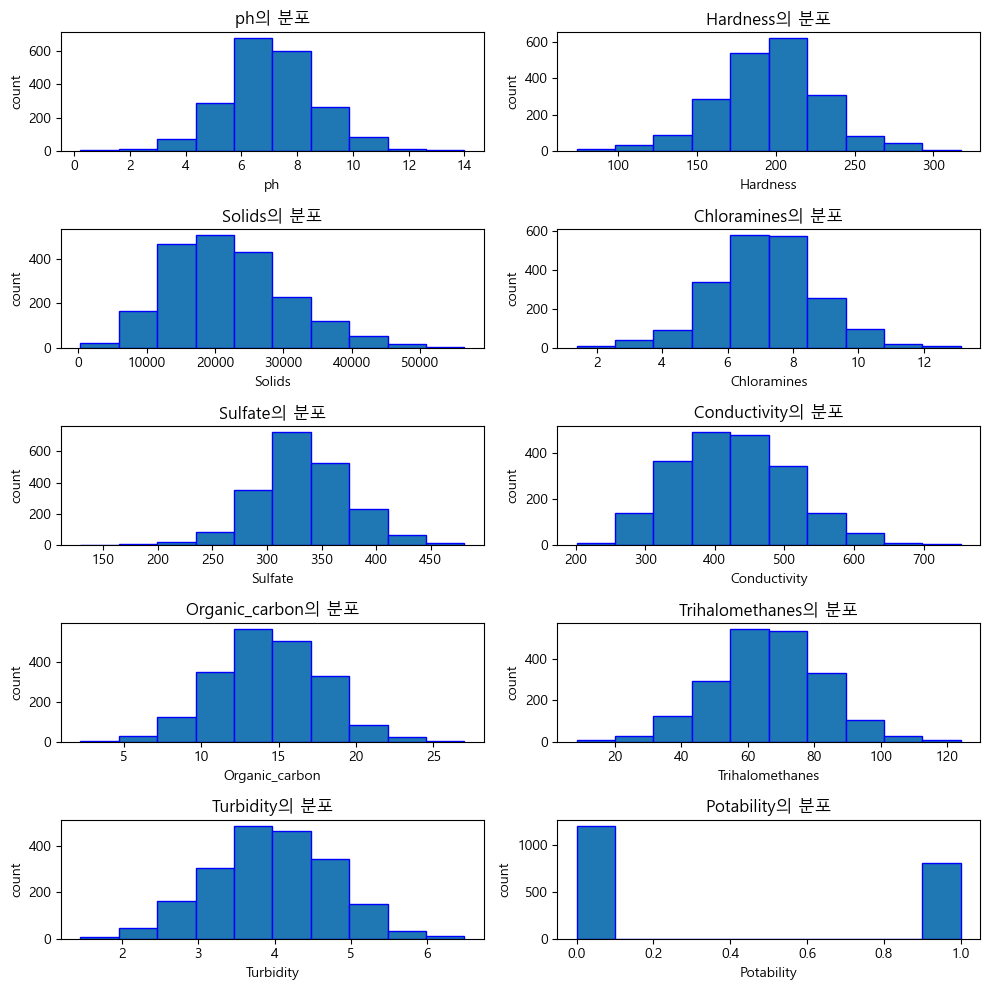

In [6]:
plt.figure(figsize = (10,10))
for i , col in enumerate(data1.columns):
    plt.subplot(5,2,i+1)
    data1[col].plot(kind = 'hist' , edgecolor = 'b')
    plt.title(f'{col}의 분포')
    plt.xlabel(col)
    plt.ylabel('count')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (20,20))
sns.pairplot(data1 , hue = 'Potability')

<Figure size 2000x2000 with 0 Axes>

<Axes: >

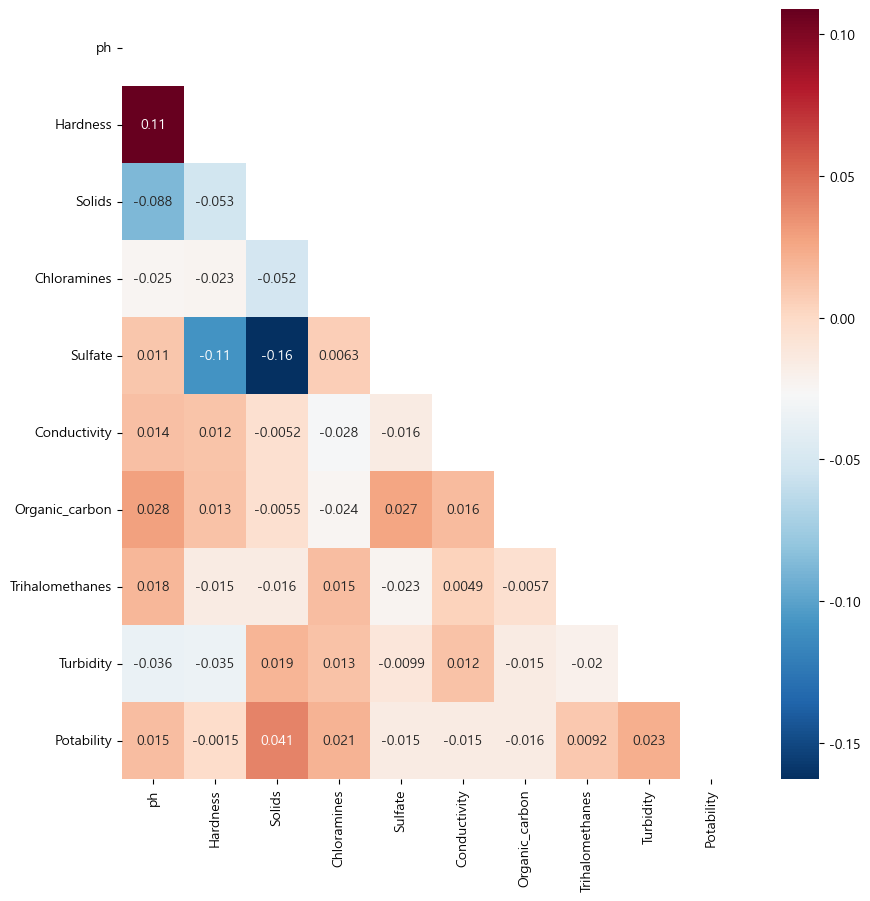

In [8]:
mask = np.triu(np.ones_like(data1.corr()))
plt.figure(figsize = (10,10))
sns.heatmap(data1.corr() , annot = True , cmap = 'RdBu_r' , mask = mask)

- 성능 내기가 상당히 어려워보인다.

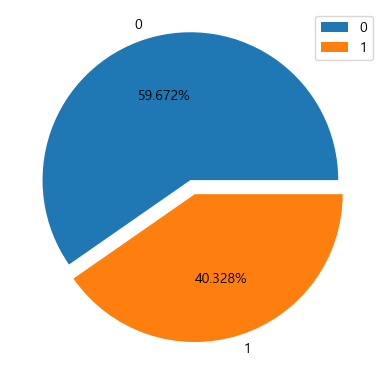

In [9]:
plt.pie(data1.Potability.value_counts() ,labels=data.Potability.unique() ,  autopct='%.3f%%' , explode = [0.1,0])
plt.legend()
plt.show()

In [10]:
data_null = data[data.ph.isna()|data.Sulfate.isna()|data.Trihalomethanes.isna()]

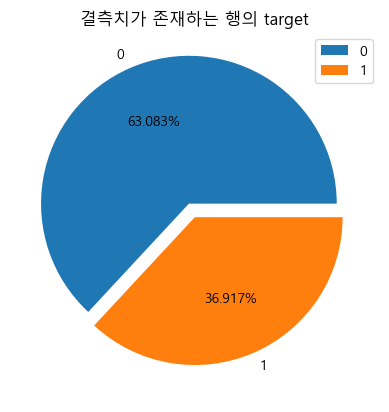

In [11]:
plt.pie(data_null.Potability.value_counts() ,labels=data.Potability.unique() ,  autopct='%.3f%%' , explode = [0.1,0])
plt.legend()
plt.title('결측치가 존재하는 행의 target')
plt.show()

- ph의 결측값은 ph의 평균값으로 대체

In [12]:
df = data.copy()
df.dropna(subset = ['ph'] , inplace = True)

In [13]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [14]:
data.ph.fillna(df.ph.mean() , inplace = True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- Trihalomethanes : 물 속의 트리할로메탄 농도
- Conductivity: 물의 전기 전도도.

- 할로메탄이란?
 - 염소 소독시 발생하는 발암물질이다.

- 위 두 개의 변수의 결측치를 채우기 위해 모델학습 이용

In [16]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

## 결측치가 있는 행을 제거한 후 , 거기에서 채울 열을 제거해서 학습시킬 데이터 생성

In [17]:
fill_Tri = data.dropna(subset = ['Trihalomethanes']).drop(['Trihalomethanes' , 'Potability' , 'Sulfate'] , axis = 1)
fill_Tri_target = data.dropna(subset = ['Trihalomethanes'])['Trihalomethanes']

In [18]:
fill_Tri.shape , fill_Tri_target.shape

((3114, 7), (3114,))

In [19]:
fill_target = data[data.Trihalomethanes.isna()].dropna(axis = 1).drop('Potability' , axis = 1)

In [20]:
fill_target.shape

(162, 7)

## 결측치 채우는 함수 정의

In [21]:
def standard(fit_model , transform_model):
    ss = StandardScaler()
    ss.fit(fit_model)
    return ss.transform(transform_model)

In [22]:
fill_Tri_scaled = standard(fill_Tri , fill_Tri)
fill_target_scaled = standard(fill_Tri , fill_target)

In [23]:
def grid(model , train_input , train_target):
    params = {'RandomForestRegressor' : { 'n_estimators' : [10, 100],
                                         'max_depth' : [6, 8, 10],
                                         'min_samples_leaf' : [8, 12],
                                         'min_samples_split' : [8, 16]},
              'Ridge' : {'alpha' : [0.001,0.01,0.1,1,10]},
              'LinearRegression' : {'n_jobs' : [1,-1]},
              'SVC' : {'C' : [0.001 , 0.01 , 0.1 , 1],
                       'kernel' : ['poly','rbf'],
                       'gamma' : [0.0001 , 0.001 , 0.01 , 0.1]},
              'RandomForestClassifier' : { 'n_estimators' : [10, 100],
                                          'max_depth' : [6, 8, 10],
                                          'min_samples_leaf' : [8, 12],
                                          'min_samples_split' : [8, 16]}
             }
    model_best = []
    for i in model:
        gs = GridSearchCV(i , params[i.__class__.__name__] , cv = 10)
        gs.fit(train_input , train_target)
        model_best.append(gs.best_estimator_)
    return model_best

In [24]:
model = [Ridge(random_state = 42) , RandomForestRegressor(random_state = 42) , LinearRegression()]
best_model = grid(model , fill_Tri_scaled , fill_Tri_target)

In [25]:
best_model

[Ridge(alpha=10, random_state=42),
 RandomForestRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=8,
                       random_state=42),
 LinearRegression(n_jobs=1)]

In [26]:
def fit(model , data , target , fill_target):
    model.fit(data , target)
    return model.predict(fill_target)

## 3개의 모델로 학습시켜서 예측한 값을 result에 저장하고 , 3개의 값의 평균으로 결측치 대체

In [27]:
result = []
for i in best_model:
    result.append(fit(i , fill_Tri_scaled , fill_Tri_target , fill_target_scaled))

In [28]:
Tri_fill = np.mean(result , axis = 0)

In [29]:
data.loc[data['Trihalomethanes'].isna(), 'Trihalomethanes'] = Tri_fill

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [31]:
fill_Sul = data.dropna(subset = ['Sulfate']).drop(['Potability' , 'Sulfate'] , axis = 1)
fill_Sul_target = data.dropna(subset = ['Sulfate'])['Sulfate']

In [32]:
fill_Sul.shape , fill_Sul_target.shape

((2495, 8), (2495,))

In [33]:
fill_target_Sul = data[data.Sulfate.isna()].dropna(axis = 1).drop('Potability' , axis = 1)

In [34]:
fill_Sul_scaled = standard(fill_Sul , fill_Sul)
fill_target_Sul_scaled = standard(fill_Sul , fill_target_Sul)

In [35]:
model = [Ridge(random_state = 42) , RandomForestRegressor(random_state = 42) , LinearRegression()]
best_model = grid(model , fill_Sul_scaled , fill_Sul_target)

In [36]:
best_model

[Ridge(alpha=10, random_state=42),
 RandomForestRegressor(max_depth=6, min_samples_leaf=12, min_samples_split=8,
                       random_state=42),
 LinearRegression(n_jobs=1)]

In [37]:
Sulfate = []

for i in best_model:
    Sulfate.append(fit(i , fill_Sul_scaled , fill_Sul_target , fill_target_Sul_scaled))

In [38]:
Sul_fill = np.mean(Sulfate , axis = 0)

In [39]:
data.loc[data['Sulfate'].isna(), 'Sulfate'] = Sul_fill

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- 결측치 대체 완료

In [41]:
data.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

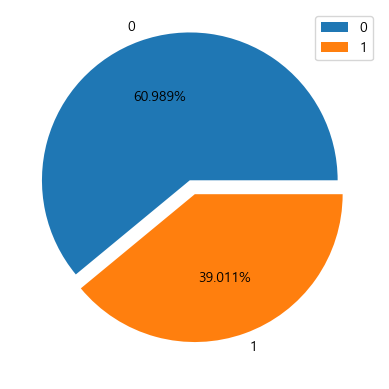

In [42]:
plt.pie(data.Potability.value_counts() ,labels=data.Potability.unique() ,  autopct='%.3f%%' , explode = [0.1,0])
plt.legend()
plt.show()

## 학습 데이터와 테스트 데이터로 나누고 , StandScaler를 이용한 정규화

In [43]:
def divide(x , y):
    train_input , test_input , train_target , test_target = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 42)
    ss = StandardScaler()
    train_scaled = ss.fit_transform(train_input)
    test_scaled = ss.transform(test_input)
    
    return train_scaled , test_scaled , train_target , test_target

In [44]:
train_input , test_input , train_target , test_target =divide(data.iloc[:,:-1] , data.iloc[:,-1])

In [45]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_input , train_target)
print(classification_report(test_target , rf.predict(test_input)))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       400
           1       0.64      0.31      0.42       256

    accuracy                           0.66       656
   macro avg       0.65      0.60      0.59       656
weighted avg       0.66      0.66      0.63       656



## 교차검증

In [46]:
scores = cross_validate(rf , train_input , train_target , cv = 10 , scoring = 'precision')
np.mean(scores['test_score'])

0.6278899706951955

In [47]:
scores = cross_validate(rf , train_input , train_target , cv = 10)
np.mean(scores['test_score'])

0.6622137404580153

## 특성공학을 이용하여 feature의 개수 늘리기

In [48]:

def poly(train_input , test_input):
    poly = PF(include_bias = False)
    train_poly = poly.fit_transform(train_input)
    test_poly = poly.transform(test_input)
    return train_poly , test_poly

In [49]:
train_poly , test_poly = poly(train_input, test_input)

In [50]:
train_poly.shape , train_input.shape

((2620, 54), (2620, 9))

- 특성이 늘어남.

In [51]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_poly , train_target)
print(classification_report(test_target , rf.predict(test_poly)))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77       400
           1       0.68      0.32      0.44       256

    accuracy                           0.68       656
   macro avg       0.68      0.61      0.61       656
weighted avg       0.68      0.68      0.64       656



- 효과가 미미하다.

## 모든 분류모델을 써서 '정밀도'를 측정해보기

In [52]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,3276.0,7.080795,1.469956,0.000000,6.277673,7.080795,7.870050,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,3276.0,333.789000,36.402113,129.000000,316.134811,333.499870,350.762716,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3276.0,66.397363,15.770505,0.738000,56.647656,66.493499,76.666609,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


In [53]:
kn = KNeighborsClassifier()
lr = LogisticRegression(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
svc = SVC(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgb = LGBMClassifier(random_state = 42)


model = [kn,lr,rf,svc,xgb,lgb]

In [54]:
#정확도 , 정밀도를 측정
def add_precision(model):
    names.append(model.__class__.__name__)
    model.fit(train_input , train_target)
    precision.append(precision_score(test_target , model.predict(test_input)))
    accuracy.append(accuracy_score(test_target , model.predict(test_input)))

In [55]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

train_input , test_input , train_target , test_target = divide(x , y)

In [56]:
names = []
precision = []
accuracy = []
for i in model:
    add_precision(i)

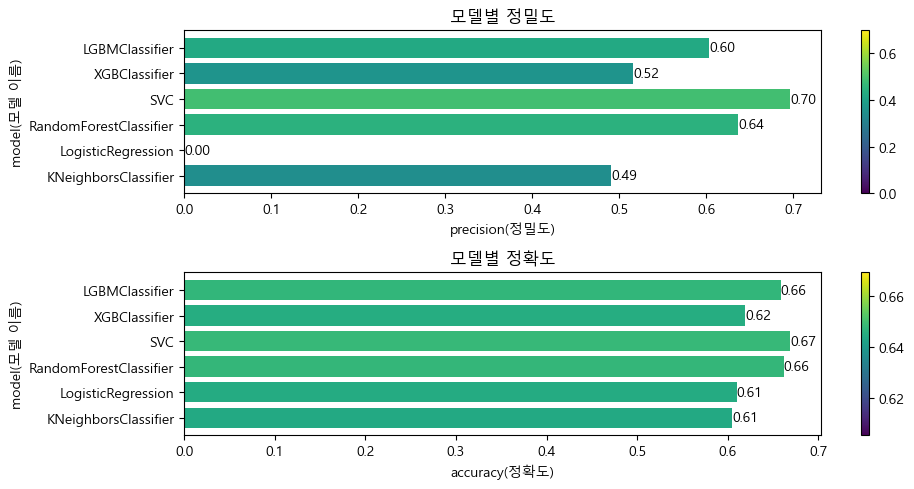

In [57]:
plt.figure(figsize = (10,5))
plt.subplot(2,1,1)
plt.barh(names , precision , color=plt.cm.viridis(precision))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(precision), vmax=max(precision)))
cbar = plt.colorbar(sm)

for i, val in enumerate(precision):
    plt.text(val, i, f'{val:.2f}', va='center')
    
plt.xlabel('precision(정밀도)')
plt.ylabel('model(모델 이름)')
plt.title('모델별 정밀도')

plt.subplot(2,1,2)
plt.barh(names , accuracy , color=plt.cm.viridis(accuracy))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(accuracy), vmax=max(accuracy)))
cbar = plt.colorbar(sm)
for i, val in enumerate(accuracy):
    plt.text(val, i, f'{val:.2f}', va='center')
    
plt.xlabel('accuracy(정확도)')
plt.ylabel('model(모델 이름)')
plt.title('모델별 정확도')


plt.tight_layout()

plt.show()

## 정밀도가 중요하다고 판단 , 정밀도를 올리는 방향

### SVM

In [58]:
train_poly , test_poly = poly(train_input, test_input)

In [59]:
svc.fit(train_poly , train_target)

SVC(random_state=42)

In [60]:
def text(plot):
    for i in plot:
        height = i.get_height()
        plt.text(i.get_x()+i.get_width()/2.0,height,  round(height, 2) ,  ha = 'center',va='bottom',size=12)

In [61]:
def poly_comparison(model , train_input , test_input):
    train_poly , test_poly = poly(train_input , test_input)
    p_list = ['No' , 'Yes']
    prec = []
    accu = []
    model.fit(train_input , train_target)
    prec.append(precision_score(test_target , model.predict(test_input)))
    accu.append(accuracy_score(test_target , model.predict(test_input)))
    
    model.fit(train_poly , train_target)
    prec.append(precision_score(test_target , model.predict(test_poly)))
    accu.append(accuracy_score(test_target , model.predict(test_poly)))
    
    plt.figure(figsize = (10,5))
    width = 0.2
    pre = plt.bar(np.arange(len(p_list))-width/2 , prec ,width = width , color = 'r' , label = 'precision')
    acc = plt.bar(np.arange(len(p_list))+width/2 , accu ,width = width , color = 'k' , label = 'accuracy')
    plt.xticks(np.arange(len(p_list)) , p_list)
    plt.legend(loc = 'upper center')
    plt.xlabel('특성공학 여부')
    plt.ylim(0.6 , 0.7)
    plt.ylabel('수치')
    plt.title('특성공학 여부에 따른 정확도와 정밀도')
    for i in [pre , acc]:
        text(i)
    plt.show()

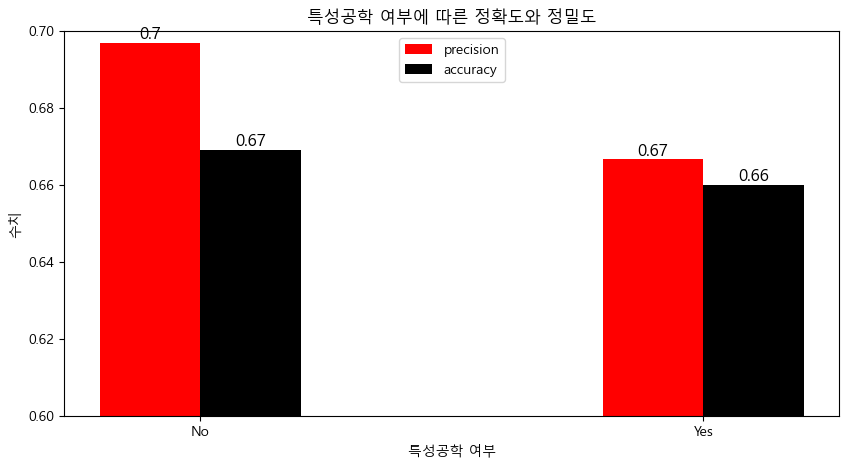

In [62]:
poly_comparison(svc , train_input , test_input)

In [63]:
svc_best = grid([SVC(random_state = 42 , probability=True)] , train_input , train_target)
svc_best

[SVC(C=1, gamma=0.1, probability=True, random_state=42)]

In [64]:
svc_best = svc_best[0]

In [65]:
svc_best.fit(train_input , train_target)

SVC(C=1, gamma=0.1, probability=True, random_state=42)

In [66]:
pred = svc_best.decision_function(test_input)

In [67]:
confusion_matrix(test_target , svc_best.predict(test_input))

array([[372,  28],
       [190,  66]], dtype=int64)

In [68]:
print(classification_report(test_target , svc_best.predict(test_input)))

              precision    recall  f1-score   support

           0       0.66      0.93      0.77       400
           1       0.70      0.26      0.38       256

    accuracy                           0.67       656
   macro avg       0.68      0.59      0.58       656
weighted avg       0.68      0.67      0.62       656



In [69]:
svc_best.predict_proba(test_input)

array([[0.77541742, 0.22458258],
       [0.80223513, 0.19776487],
       [0.80184952, 0.19815048],
       ...,
       [0.6236285 , 0.3763715 ],
       [0.73972162, 0.26027838],
       [0.60709308, 0.39290692]])

In [70]:
def proba(model):
    fper , tper , thresholds = roc_curve(test_target , model.predict_proba(test_input)[:,1])
    return fper , tper , thresholds

In [71]:
fper , tper , thresholds = proba(svc_best)

In [72]:
roc_auc_score(test_target , svc_best.predict_proba(test_input)[:,1])

0.6476123046875

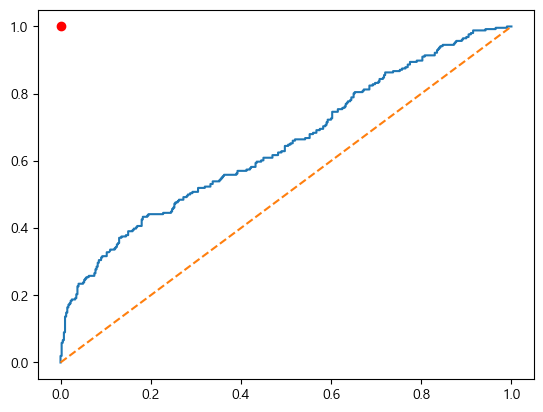

In [73]:
plt.plot(fper , tper)
plt.scatter(0,1 , color = 'red')
plt.plot([0,1] , [0,1] , ls = '--')
plt.show()

- x축 : 정답이 Negative(0)인 것 중에서 모델이 Positive라고 잘못 예측한 것의 비율이 된다.
- y축 : 정답이 Positive(1)인 것들 중에서 정말로 정답을 맞춘 수의 비율이 된다. (재현율)

### RandomForestClassification

In [74]:
rf_best = grid([RandomForestClassifier(random_state = 42)] , train_input , train_target)

In [75]:
rf_best = rf_best[0]

In [76]:
rf_best.fit(train_input , train_target)

RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8,
                       random_state=42)

In [77]:
rf_best.predict_proba(test_input)

array([[0.67966937, 0.32033063],
       [0.71645111, 0.28354889],
       [0.63582395, 0.36417605],
       ...,
       [0.67555439, 0.32444561],
       [0.68443376, 0.31556624],
       [0.56179748, 0.43820252]])

In [78]:
print(classification_report(test_target , rf_best.predict(test_input)))

              precision    recall  f1-score   support

           0       0.65      0.94      0.77       400
           1       0.71      0.22      0.33       256

    accuracy                           0.66       656
   macro avg       0.68      0.58      0.55       656
weighted avg       0.68      0.66      0.60       656



In [79]:
imp = rf_best.feature_importances_

In [80]:
imp2 = []
for i in imp:
    imp2.append(round(i , 3))

In [81]:
col = data.columns[:-1]

In [82]:
feature = dict(zip(col , imp2))

In [83]:
feature

{'ph': 0.164,
 'Hardness': 0.124,
 'Solids': 0.113,
 'Chloramines': 0.109,
 'Sulfate': 0.206,
 'Conductivity': 0.082,
 'Organic_carbon': 0.069,
 'Trihalomethanes': 0.07,
 'Turbidity': 0.063}

In [84]:
fper , tper , thresholds = proba(rf_best)

In [85]:
roc_auc_score(test_target , rf_best.predict_proba(test_input)[:,1])

0.659560546875

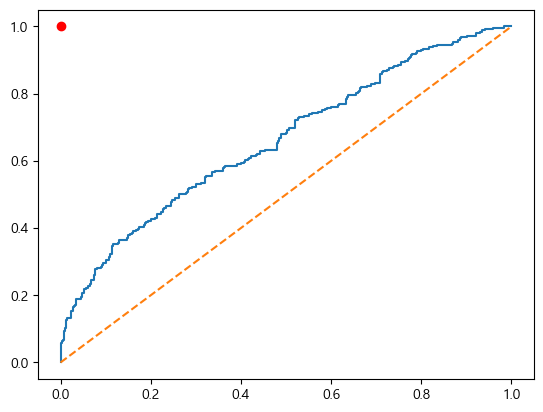

In [86]:
plt.plot(fper , tper)
plt.scatter(0,1 , color = 'red')
plt.plot([0,1] , [0,1] , ls = '--')

In [87]:
def acc_pred(model):
    try:
        thresholds_list = [0.1,0.2,0.3,0.4 , 0.5]
        pred = model.decision_function(test_input)
    except:
        thresholds_list = [0.4,0.45,0.5,0.55,0.6]
        pred = model.predict_proba(test_input)[:,1]
    


    accuracy_list = []
    precision_list = []
    for i in thresholds_list:
        y_pred = np.where(pred>i , 1 , 0)
        acc = accuracy_score(test_target , y_pred)
        precision = precision_score(test_target , y_pred)
        accuracy_list.append(acc)
        precision_list.append(precision)
#         print(f'임계값 : {i}')
#         print(f'정확도 : {acc:.4f}\n정밀도 : {precision:.4f}')
#         print()
    return thresholds_list , accuracy_list , precision_list

In [88]:
def plotting(model1 , model2):
    thresholds_list , accuracy_list , precision_list = acc_pred(model1)
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    width = 0.3
    acc = plt.bar(np.arange(len(thresholds_list)) - width/2 , accuracy_list ,width = width ,  color = 'r' , label = '정확도')
    pre = plt.bar(np.arange(len(thresholds_list)) + width/2 , precision_list ,width = width ,  color = 'b' , label = '정밀도')

    for i in [acc , pre]:
        text(i)


    plt.xticks(np.arange(len(thresholds_list)) , thresholds_list)
    plt.xlabel('임계값')
    plt.ylabel('수치')
    plt.title(f'임계값 별 정밀도와 정확도({model1.__class__.__name__})')
    plt.legend(loc = 'upper center')
    plt.ylim(0.6 , 0.9)
    
    plt.subplot(1,2,2)
    thresholds_list , accuracy_list , precision_list = acc_pred(model2)
    width = 0.3
    acc = plt.bar(np.arange(len(thresholds_list)) - width/2 , accuracy_list ,width = width ,  color = 'r' , label = '정확도')
    pre = plt.bar(np.arange(len(thresholds_list)) + width/2 , precision_list ,width = width ,  color = 'b' , label = '정밀도')

    for i in [acc , pre]:
        text(i)


    plt.xticks(np.arange(len(thresholds_list)) , thresholds_list)
    plt.xlabel('임계값')
    plt.ylabel('수치')
    plt.title(f'임계값 별 정밀도와 정확도({model2.__class__.__name__})')
    plt.legend(loc = 'upper center')
    plt.ylim(0.5 , 0.9)

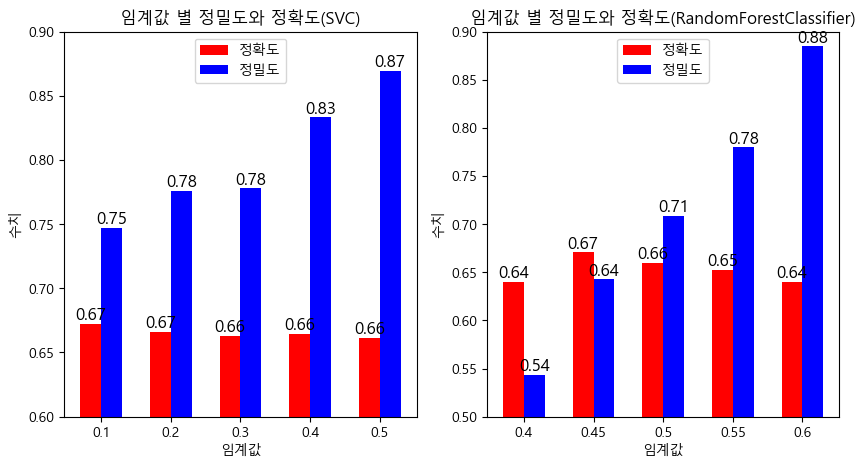

In [89]:
plotting(svc_best , rf_best)

# 결론

In [90]:
print('SVC')
for i in [0.4, 0.5]:
    predic = np.where(svc_best.decision_function(test_input)>i , 1 , 0)
    print(f'임계값 : {i}')
    print(confusion_matrix(test_target , predic))
    print()
    
print('RandomForest')
for i in [0.55 , 0.6]:
    predic = np.where(rf_best.predict_proba(test_input)[:,1] > i , 1 , 0)
    print(f'임계값 : {i}')
    print(confusion_matrix(test_target , predic))
    print()

SVC
임계값 : 0.4
[[391   9]
 [211  45]]

임계값 : 0.5
[[394   6]
 [216  40]]

RandomForest
임계값 : 0.55
[[389  11]
 [217  39]]

임계값 : 0.6
[[397   3]
 [233  23]]



- TP가 가장 많은 것 채택

In [91]:
prediction = np.where(svc_best.decision_function(test_input) > 0.4 , 1 , 0)

In [92]:
print(classification_report(test_target , prediction))

              precision    recall  f1-score   support

           0       0.65      0.98      0.78       400
           1       0.83      0.18      0.29       256

    accuracy                           0.66       656
   macro avg       0.74      0.58      0.54       656
weighted avg       0.72      0.66      0.59       656



- 정확도를 적당히 잃으면서 정밀도를 끌어올렸다.

- 출처 : https://www.kaggle.com/datasets/adityakadiwal/water-potability

In [94]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/fb/59/3eb58629e3749d9f4fc1e522487af369f9bd4c451f465d3054961fab6bf8/tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5b/6f/8b125d126d54061c0be610b135aaf2f8960f55c2e185ac32445e4a5012d5/tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/38/ba/dd4d998a852451e98dc009ecb208bbb0eeb0c8252dc35b7c4e1050762b36/tensorflow_intel-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.w

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
pyls-black 0.4.6 requires black>=19.3b0, but you have black 0.0 which is incompatible.


In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [121]:
model = Sequential()
model.add(Dense(20 , input_dim = 9 , activation = 'relu'))
model.add(Dense(1 , activation = 'sigmoid'))

In [125]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [123]:
train_input.shape , train_target.shape

((2620, 9), (2620,))

In [124]:
train_input

array([[ 0.50072818,  0.37129458,  0.04803985, ...,  0.56524237,
        -0.36488845, -0.17745664],
       [-0.71408938,  0.93508365, -1.01608039, ..., -2.16944822,
        -1.5808601 , -0.48650158],
       [ 0.9245226 ,  0.98071034,  0.80819229, ...,  0.08540402,
        -0.35106886,  0.5472018 ],
       ...,
       [ 0.05259378,  0.22250815,  1.40869927, ...,  0.59112626,
         1.5214406 , -0.79398318],
       [-0.30016158, -0.80447188,  0.17629195, ...,  1.81798425,
         0.80697624,  0.25234143],
       [-0.31897627,  1.1381894 , -0.26137162, ..., -0.76051077,
         0.44548214,  0.59461298]])

In [127]:
model.fit(train_input , train_target , epochs = 1000)

Epoch 1/1000
82/82 [==============================] - 0s 960us/step - loss: 0.5601 - accuracy: 0.7118
Epoch 2/1000
82/82 [==============================] - 0s 872us/step - loss: 0.5599 - accuracy: 0.7095
Epoch 3/1000
82/82 [==============================] - 0s 867us/step - loss: 0.5595 - accuracy: 0.7149
Epoch 4/1000
82/82 [==============================] - 0s 884us/step - loss: 0.5591 - accuracy: 0.7107
Epoch 5/1000
82/82 [==============================] - 0s 881us/step - loss: 0.5595 - accuracy: 0.7107
Epoch 6/1000
82/82 [==============================] - 0s 867us/step - loss: 0.5588 - accuracy: 0.7095
Epoch 7/1000
82/82 [==============================] - 0s 863us/step - loss: 0.5589 - accuracy: 0.7130
Epoch 8/1000
82/82 [==============================] - 0s 882us/step - loss: 0.5592 - accuracy: 0.7099
Epoch 9/1000
82/82 [==============================] - 0s 882us/step - loss: 0.5588 - accuracy: 0.7145
Epoch 10/1000
82/82 [==============================] - 0s 927us/step - loss: 0.558

Epoch 81/1000
82/82 [==============================] - 0s 1ms/step - loss: 0.5485 - accuracy: 0.7191
Epoch 82/1000
82/82 [==============================] - 0s 856us/step - loss: 0.5488 - accuracy: 0.7198
Epoch 83/1000
82/82 [==============================] - 0s 846us/step - loss: 0.5482 - accuracy: 0.7229
Epoch 84/1000
82/82 [==============================] - 0s 841us/step - loss: 0.5492 - accuracy: 0.7218
Epoch 85/1000
82/82 [==============================] - 0s 847us/step - loss: 0.5484 - accuracy: 0.7221
Epoch 86/1000
82/82 [==============================] - 0s 854us/step - loss: 0.5480 - accuracy: 0.7195
Epoch 87/1000
82/82 [==============================] - 0s 844us/step - loss: 0.5480 - accuracy: 0.7244
Epoch 88/1000
82/82 [==============================] - 0s 866us/step - loss: 0.5479 - accuracy: 0.7252
Epoch 89/1000
82/82 [==============================] - 0s 908us/step - loss: 0.5474 - accuracy: 0.7214
Epoch 90/1000
82/82 [==============================] - 0s 866us/step - loss

82/82 [==============================] - 0s 893us/step - loss: 0.5388 - accuracy: 0.7336
Epoch 161/1000
82/82 [==============================] - 0s 852us/step - loss: 0.5392 - accuracy: 0.7298
Epoch 162/1000
82/82 [==============================] - 0s 848us/step - loss: 0.5386 - accuracy: 0.7340
Epoch 163/1000
82/82 [==============================] - 0s 951us/step - loss: 0.5387 - accuracy: 0.7351
Epoch 164/1000
82/82 [==============================] - 0s 829us/step - loss: 0.5388 - accuracy: 0.7351
Epoch 165/1000
82/82 [==============================] - 0s 841us/step - loss: 0.5389 - accuracy: 0.7305
Epoch 166/1000
82/82 [==============================] - 0s 883us/step - loss: 0.5378 - accuracy: 0.7298
Epoch 167/1000
82/82 [==============================] - 0s 837us/step - loss: 0.5384 - accuracy: 0.7328
Epoch 168/1000
82/82 [==============================] - 0s 866us/step - loss: 0.5381 - accuracy: 0.7363
Epoch 169/1000
82/82 [==============================] - 0s 882us/step - loss: 0

82/82 [==============================] - 0s 926us/step - loss: 0.5317 - accuracy: 0.7382
Epoch 240/1000
82/82 [==============================] - 0s 858us/step - loss: 0.5309 - accuracy: 0.7378
Epoch 241/1000
82/82 [==============================] - 0s 854us/step - loss: 0.5305 - accuracy: 0.7427
Epoch 242/1000
82/82 [==============================] - 0s 866us/step - loss: 0.5312 - accuracy: 0.7393
Epoch 243/1000
82/82 [==============================] - 0s 842us/step - loss: 0.5304 - accuracy: 0.7393
Epoch 244/1000
82/82 [==============================] - 0s 867us/step - loss: 0.5313 - accuracy: 0.7450
Epoch 245/1000
82/82 [==============================] - 0s 843us/step - loss: 0.5307 - accuracy: 0.7397
Epoch 246/1000
82/82 [==============================] - 0s 846us/step - loss: 0.5304 - accuracy: 0.7477
Epoch 247/1000
82/82 [==============================] - 0s 901us/step - loss: 0.5310 - accuracy: 0.7389
Epoch 248/1000
82/82 [==============================] - 0s 860us/step - loss: 0

Epoch 318/1000
82/82 [==============================] - 0s 1ms/step - loss: 0.5245 - accuracy: 0.7435
Epoch 319/1000
82/82 [==============================] - 0s 859us/step - loss: 0.5242 - accuracy: 0.7397
Epoch 320/1000
82/82 [==============================] - 0s 815us/step - loss: 0.5245 - accuracy: 0.7420
Epoch 321/1000
82/82 [==============================] - 0s 826us/step - loss: 0.5237 - accuracy: 0.7389
Epoch 322/1000
82/82 [==============================] - 0s 850us/step - loss: 0.5244 - accuracy: 0.7416
Epoch 323/1000
82/82 [==============================] - 0s 861us/step - loss: 0.5237 - accuracy: 0.7416
Epoch 324/1000
82/82 [==============================] - 0s 857us/step - loss: 0.5241 - accuracy: 0.7405
Epoch 325/1000
82/82 [==============================] - 0s 830us/step - loss: 0.5241 - accuracy: 0.7454
Epoch 326/1000
82/82 [==============================] - 0s 827us/step - loss: 0.5238 - accuracy: 0.7385
Epoch 327/1000
82/82 [==============================] - 0s 863us/s

82/82 [==============================] - 0s 810us/step - loss: 0.5199 - accuracy: 0.7382
Epoch 397/1000
82/82 [==============================] - 0s 819us/step - loss: 0.5188 - accuracy: 0.7405
Epoch 398/1000
82/82 [==============================] - 0s 817us/step - loss: 0.5185 - accuracy: 0.7443
Epoch 399/1000
82/82 [==============================] - 0s 833us/step - loss: 0.5188 - accuracy: 0.7443
Epoch 400/1000
82/82 [==============================] - 0s 843us/step - loss: 0.5188 - accuracy: 0.7443
Epoch 401/1000
82/82 [==============================] - 0s 820us/step - loss: 0.5190 - accuracy: 0.7462
Epoch 402/1000
82/82 [==============================] - 0s 826us/step - loss: 0.5189 - accuracy: 0.7427
Epoch 403/1000
82/82 [==============================] - 0s 845us/step - loss: 0.5183 - accuracy: 0.7431
Epoch 404/1000
82/82 [==============================] - 0s 842us/step - loss: 0.5189 - accuracy: 0.7401
Epoch 405/1000
82/82 [==============================] - 0s 1ms/step - loss: 0.5

Epoch 475/1000
82/82 [==============================] - 0s 809us/step - loss: 0.5155 - accuracy: 0.7443
Epoch 476/1000
82/82 [==============================] - 0s 834us/step - loss: 0.5164 - accuracy: 0.7466
Epoch 477/1000
82/82 [==============================] - 0s 824us/step - loss: 0.5153 - accuracy: 0.7515
Epoch 478/1000
82/82 [==============================] - 0s 840us/step - loss: 0.5158 - accuracy: 0.7508
Epoch 479/1000
82/82 [==============================] - 0s 795us/step - loss: 0.5151 - accuracy: 0.7466
Epoch 480/1000
82/82 [==============================] - 0s 846us/step - loss: 0.5150 - accuracy: 0.7492
Epoch 481/1000
82/82 [==============================] - 0s 841us/step - loss: 0.5153 - accuracy: 0.7473
Epoch 482/1000
82/82 [==============================] - 0s 833us/step - loss: 0.5154 - accuracy: 0.7462
Epoch 483/1000
82/82 [==============================] - 0s 835us/step - loss: 0.5151 - accuracy: 0.7515
Epoch 484/1000
82/82 [==============================] - 0s 845us

82/82 [==============================] - 0s 830us/step - loss: 0.5128 - accuracy: 0.7492
Epoch 554/1000
82/82 [==============================] - 0s 840us/step - loss: 0.5130 - accuracy: 0.7466
Epoch 555/1000
82/82 [==============================] - 0s 843us/step - loss: 0.5124 - accuracy: 0.7469
Epoch 556/1000
82/82 [==============================] - 0s 801us/step - loss: 0.5123 - accuracy: 0.7485
Epoch 557/1000
82/82 [==============================] - 0s 839us/step - loss: 0.5122 - accuracy: 0.7489
Epoch 558/1000
82/82 [==============================] - 0s 846us/step - loss: 0.5129 - accuracy: 0.7489
Epoch 559/1000
82/82 [==============================] - 0s 823us/step - loss: 0.5130 - accuracy: 0.7519
Epoch 560/1000
82/82 [==============================] - 0s 792us/step - loss: 0.5121 - accuracy: 0.7489
Epoch 561/1000
82/82 [==============================] - 0s 802us/step - loss: 0.5124 - accuracy: 0.7473
Epoch 562/1000
82/82 [==============================] - 0s 809us/step - loss: 0

Epoch 632/1000
82/82 [==============================] - 0s 835us/step - loss: 0.5111 - accuracy: 0.7500
Epoch 633/1000
82/82 [==============================] - 0s 826us/step - loss: 0.5102 - accuracy: 0.7481
Epoch 634/1000
82/82 [==============================] - 0s 786us/step - loss: 0.5106 - accuracy: 0.7511
Epoch 635/1000
82/82 [==============================] - 0s 776us/step - loss: 0.5108 - accuracy: 0.7489
Epoch 636/1000
82/82 [==============================] - 0s 769us/step - loss: 0.5112 - accuracy: 0.7492
Epoch 637/1000
82/82 [==============================] - 0s 794us/step - loss: 0.5110 - accuracy: 0.7504
Epoch 638/1000
82/82 [==============================] - 0s 820us/step - loss: 0.5108 - accuracy: 0.7469
Epoch 639/1000
82/82 [==============================] - 0s 1ms/step - loss: 0.5110 - accuracy: 0.7477
Epoch 640/1000
82/82 [==============================] - 0s 823us/step - loss: 0.5106 - accuracy: 0.7454
Epoch 641/1000
82/82 [==============================] - 0s 826us/s

82/82 [==============================] - 0s 816us/step - loss: 0.5089 - accuracy: 0.7546
Epoch 711/1000
82/82 [==============================] - 0s 808us/step - loss: 0.5089 - accuracy: 0.7531
Epoch 712/1000
82/82 [==============================] - 0s 826us/step - loss: 0.5096 - accuracy: 0.7527
Epoch 713/1000
82/82 [==============================] - 0s 826us/step - loss: 0.5098 - accuracy: 0.7508
Epoch 714/1000
82/82 [==============================] - 0s 817us/step - loss: 0.5088 - accuracy: 0.7553
Epoch 715/1000
82/82 [==============================] - 0s 817us/step - loss: 0.5091 - accuracy: 0.7550
Epoch 716/1000
82/82 [==============================] - 0s 821us/step - loss: 0.5090 - accuracy: 0.7542
Epoch 717/1000
82/82 [==============================] - 0s 835us/step - loss: 0.5090 - accuracy: 0.7553
Epoch 718/1000
82/82 [==============================] - 0s 819us/step - loss: 0.5098 - accuracy: 0.7546
Epoch 719/1000
82/82 [==============================] - 0s 820us/step - loss: 0

Epoch 789/1000
82/82 [==============================] - 0s 817us/step - loss: 0.5082 - accuracy: 0.7519
Epoch 790/1000
82/82 [==============================] - 0s 832us/step - loss: 0.5084 - accuracy: 0.7538
Epoch 791/1000
82/82 [==============================] - 0s 839us/step - loss: 0.5081 - accuracy: 0.7542
Epoch 792/1000
82/82 [==============================] - 0s 864us/step - loss: 0.5074 - accuracy: 0.7550
Epoch 793/1000
82/82 [==============================] - 0s 806us/step - loss: 0.5075 - accuracy: 0.7569
Epoch 794/1000
82/82 [==============================] - 0s 997us/step - loss: 0.5076 - accuracy: 0.7550
Epoch 795/1000
82/82 [==============================] - 0s 832us/step - loss: 0.5076 - accuracy: 0.7580
Epoch 796/1000
82/82 [==============================] - 0s 837us/step - loss: 0.5070 - accuracy: 0.7550
Epoch 797/1000
82/82 [==============================] - 0s 819us/step - loss: 0.5074 - accuracy: 0.7504
Epoch 798/1000
82/82 [==============================] - 0s 909us

82/82 [==============================] - 0s 844us/step - loss: 0.5060 - accuracy: 0.7599
Epoch 868/1000
82/82 [==============================] - 0s 840us/step - loss: 0.5061 - accuracy: 0.7557
Epoch 869/1000
82/82 [==============================] - 0s 818us/step - loss: 0.5068 - accuracy: 0.7531
Epoch 870/1000
82/82 [==============================] - 0s 825us/step - loss: 0.5066 - accuracy: 0.7580
Epoch 871/1000
82/82 [==============================] - 0s 827us/step - loss: 0.5058 - accuracy: 0.7561
Epoch 872/1000
82/82 [==============================] - 0s 866us/step - loss: 0.5066 - accuracy: 0.7542
Epoch 873/1000
82/82 [==============================] - 0s 814us/step - loss: 0.5065 - accuracy: 0.7542
Epoch 874/1000
82/82 [==============================] - 0s 860us/step - loss: 0.5064 - accuracy: 0.7569
Epoch 875/1000
82/82 [==============================] - 0s 878us/step - loss: 0.5060 - accuracy: 0.7565
Epoch 876/1000
82/82 [==============================] - 0s 856us/step - loss: 0

82/82 [==============================] - 0s 919us/step - loss: 0.5060 - accuracy: 0.7573
Epoch 947/1000
82/82 [==============================] - 0s 887us/step - loss: 0.5060 - accuracy: 0.7553
Epoch 948/1000
82/82 [==============================] - 0s 913us/step - loss: 0.5068 - accuracy: 0.7592
Epoch 949/1000
82/82 [==============================] - 0s 922us/step - loss: 0.5058 - accuracy: 0.7573
Epoch 950/1000
82/82 [==============================] - 0s 897us/step - loss: 0.5053 - accuracy: 0.7599
Epoch 951/1000
82/82 [==============================] - 0s 817us/step - loss: 0.5057 - accuracy: 0.7557
Epoch 952/1000
82/82 [==============================] - 0s 884us/step - loss: 0.5066 - accuracy: 0.7557
Epoch 953/1000
82/82 [==============================] - 0s 928us/step - loss: 0.5058 - accuracy: 0.7553
Epoch 954/1000
82/82 [==============================] - 0s 900us/step - loss: 0.5058 - accuracy: 0.7595
Epoch 955/1000
82/82 [==============================] - 0s 891us/step - loss: 0

In [137]:
pred = np.where(model.predict(test_input)>0.5 , 1 , 0)

21/21 [==============================] - 0s 897us/step


In [141]:
print(classification_report(test_target , pred))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       400
           1       0.54      0.43      0.48       256

    accuracy                           0.64       656
   macro avg       0.61      0.60      0.60       656
weighted avg       0.63      0.64      0.63       656

